# Important Note
Completing this notebook was part of the final for Environmental Analysis using Python at UMass Lowell during the SPring 2025 semester. It was taught by Professor Mathew Barlow, and all the code in sections up til "Part 1: Add Walpole Data" were given by him. "Part 1: ..." and all sections afterwards were added by me to analyze how the data and its visual representation change. Random forest was also added to compare machine learning methods (linear regression and random forests in this case).

# Description

Google Colab python notebook that tests how well nearby stations can be used to predict Boston daily temperatures.

Using GHCND data from AWS.



# Install and import needed packages

install packages not already in Google Colab

In [ ]:
%%capture
!pip install s3fs

import needed packages

In [ ]:
import time
import s3fs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [ ]:
# general functions from sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay

In [ ]:
# specific regressors from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# correlation function
from scipy.stats import pearsonr

# Read in data from AWS

links for the data directory

In [ ]:
# directory with csv data files for each station
data_dir_url = 'https://noaa-ghcn-pds.s3.amazonaws.com/csv/by_station/'

prep for getting data from AWS

In [ ]:
fs = s3fs.S3FileSystem(anon=True)

station IDs for MA stations with good reporting

In [ ]:
Boston_ID = 'USW00014739'

Amherst_ID = 'USC00190120'
BlueHill_ID = 'USC00190736'
Edgartown_ID = 'USC00192501'
Hingham_ID = 'USC00193624	'
Norton_ID = 'USC00195984'
Walpole_ID = 'USC00198757'
Worcester_ID = 'USW00094746'

set time range for 1991-2020

In [ ]:
start_time = '1991-01-01'
end_time = '2020-12-31'

get stations with the specified ID

In [ ]:
Boston_df = pd.read_csv(data_dir_url + Boston_ID + '.csv', low_memory=False)
BlueHill_df = pd.read_csv(data_dir_url + BlueHill_ID + '.csv', low_memory=False)
Norton_df = pd.read_csv(data_dir_url + Norton_ID + '.csv', low_memory=False)
Walpole_df = pd.read_csv(data_dir_url + Walpole_ID + '.csv', low_memory=False)
Worcester_df = pd.read_csv(data_dir_url + Worcester_ID + '.csv', low_memory=False)

tidy up the representation of time in the data frame

In [ ]:
Boston_df['time'] = pd.to_datetime(Boston_df['DATE'].astype(str), format='%Y%m%d')
Boston_df.set_index('time', inplace=True)

BlueHill_df['time'] = pd.to_datetime(BlueHill_df['DATE'].astype(str), format='%Y%m%d')
BlueHill_df.set_index('time', inplace=True)

Norton_df['time'] = pd.to_datetime(Norton_df['DATE'].astype(str), format='%Y%m%d')
Norton_df.set_index('time', inplace=True)

Walpole_df['time'] = pd.to_datetime(Walpole_df['DATE'].astype(str), format='%Y%m%d')
Walpole_df.set_index('time', inplace=True)

Worcester_df['time'] = pd.to_datetime(Worcester_df['DATE'].astype(str), format='%Y%m%d')
Worcester_df.set_index('time', inplace=True)

pull out tmax and tmin, set time range

In [ ]:
Boston_tmax = Boston_df[Boston_df['ELEMENT']=='TMAX']['DATA_VALUE'].asfreq('D')
Boston_tmin = Boston_df[Boston_df['ELEMENT']=='TMIN']['DATA_VALUE'].asfreq('D')
Boston_tmax = Boston_tmax.loc[start_time:end_time]/10
Boston_tmin = Boston_tmin.loc[start_time:end_time]/10

BlueHill_tmax = BlueHill_df[BlueHill_df['ELEMENT']=='TMAX']['DATA_VALUE'].asfreq('D')
BlueHill_tmin = BlueHill_df[BlueHill_df['ELEMENT']=='TMIN']['DATA_VALUE'].asfreq('D')
BlueHill_tmax = BlueHill_tmax.loc[start_time:end_time]/10
BlueHill_tmin = BlueHill_tmin.loc[start_time:end_time]/10

Norton_tmax = Norton_df[Norton_df['ELEMENT']=='TMAX']['DATA_VALUE'].asfreq('D')
Norton_tmin = Norton_df[Norton_df['ELEMENT']=='TMIN']['DATA_VALUE'].asfreq('D')
Norton_tmax = Norton_tmax.loc[start_time:end_time]/10
Norton_tmin = Norton_tmin.loc[start_time:end_time]/10

Walpole_tmax = Walpole_df[Walpole_df['ELEMENT']=='TMAX']['DATA_VALUE'].asfreq('D')
Walpole_tmin = Walpole_df[Walpole_df['ELEMENT']=='TMIN']['DATA_VALUE'].asfreq('D')
Walpole_tmax = Walpole_tmax.loc[start_time:end_time]/10
Walpole_tmin = Walpole_tmin.loc[start_time:end_time]/10

Worcester_tmax = Worcester_df[Worcester_df['ELEMENT']=='TMAX']['DATA_VALUE'].asfreq('D')
Worcester_tmin = Worcester_df[Worcester_df['ELEMENT']=='TMIN']['DATA_VALUE'].asfreq('D')
Worcester_tmax = Worcester_tmax.loc[start_time:end_time]/10
Worcester_tmin = Worcester_tmin.loc[start_time:end_time]/10

do a basic data check

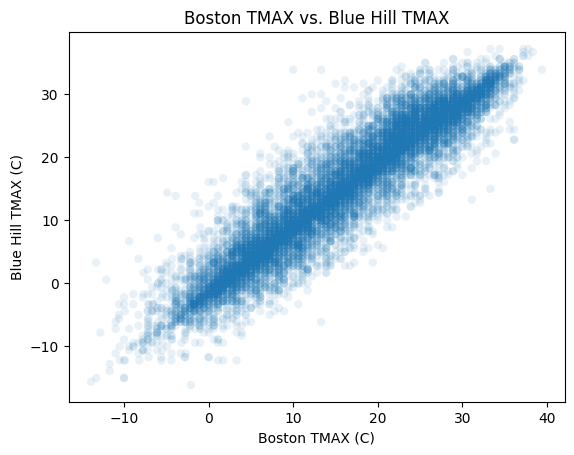

In [ ]:
plt.scatter(Boston_tmax, BlueHill_tmax, alpha=0.1, edgecolor='none')
plt.xlabel('Boston TMAX (C)')
plt.ylabel('Blue Hill TMAX (C)')
plt.title('Boston TMAX vs. Blue Hill TMAX')
plt.show()

#ML prediction of Boston TMAX from nearby stations

our variables (features) will be temperatures at other stations

In [ ]:
feature_1 = BlueHill_tmax.values
feature_2 = Norton_tmax.values

our labels will be the Boston temperatures

In [ ]:
labels = Boston_tmax.values

convert to the format expected by sklearn  

In [ ]:
X = np.stack((feature_1, feature_2), axis=1)
y = labels

remove any samples that have an undefined value in any of the features or labels

In [ ]:
# nan values in X
index_nan_X = np.sum(np.isnan(X), axis=1)
# nan values in y
index_nan_y = np.isnan(y)
# all nan values
index_nan = index_nan_X + index_nan_y
index_nan = index_nan.astype(np.bool)

# keep values that are not nan
X = X[~index_nan]
y = y[~index_nan]

## Linear Regression

divide data into training and testing sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5)

train regression model and make prediction

In [ ]:
# define model
reg = LinearRegression()
# train model
reg.fit(X_train, y_train)
# make prediction
y_predict = reg.predict(X_test)
# correlation between prediction and true values
cor, p = pearsonr(y_predict, y_test)
print('correlation:', np.round(cor, 4))

correlation: 0.9477


make scatter plot of predicted vs true values

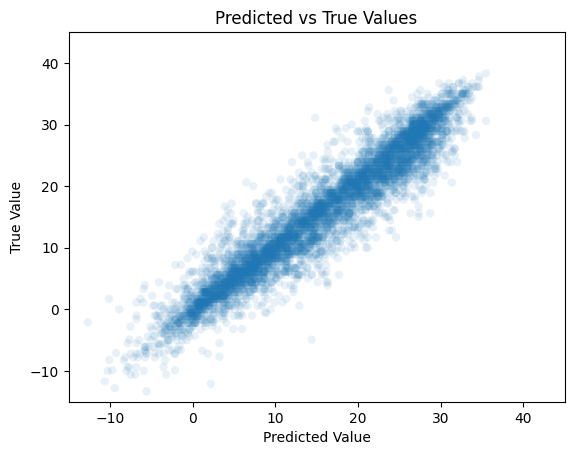

In [ ]:
plt.scatter(y_predict, y_test, alpha=0.1, edgecolor='none')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title ('Predicted vs True Values')
plt.xlim(-15, 45)
plt.ylim(-15, 45)
plt.show()

# Part 1: Add Walpole Data
Let's redo the previous steps but lets include Walpole data and see how results differ

Add a feature for Walpole data

In [ ]:
feature_1 = BlueHill_tmax.values
feature_2 = Norton_tmax.values
feature_3 = Walpole_tmax.values

Labels are still Boston temperatures


In [ ]:
labels = Boston_tmax.values

Convert data to be understood by Scikit, but include Walpole data

In [ ]:
X = np.stack((feature_1, feature_2, feature_3), axis=1)
y = labels

remove undefined values

In [ ]:
# nan values in X
index_nan_X = np.sum(np.isnan(X), axis=1)
# nan values in y
index_nan_y = np.isnan(y)
# all nan values
index_nan = index_nan_X + index_nan_y
index_nan = index_nan.astype(np.bool)

# keep values that are not nan
X = X[~index_nan]
y = y[~index_nan]

divide data into training and testing sets for linear regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5)

Train model and make prediction

In [ ]:
# define model
reg = LinearRegression()
# train model
reg.fit(X_train, y_train)
# make prediction
y_predict = reg.predict(X_test)
# correlation between prediction and true values
cor, p = pearsonr(y_predict, y_test)
print('correlation:', np.round(cor, 4))

correlation: 0.9798


make scatterplot of true vs predicted values

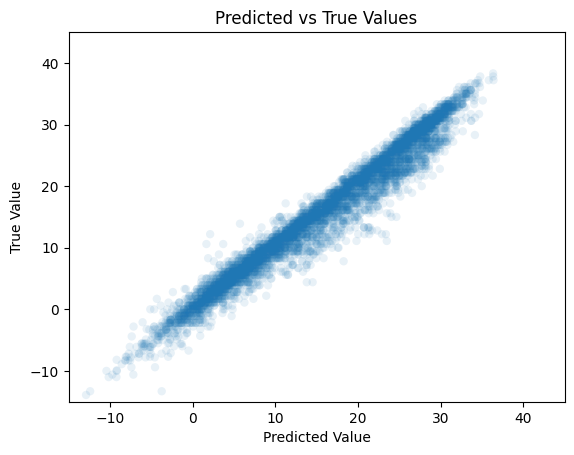

In [ ]:
plt.scatter(y_predict, y_test, alpha=0.1, edgecolor='none')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title ('Predicted vs True Values')
plt.xlim(-15, 45)
plt.ylim(-15, 45)
plt.show()

# Comparison of Predictions
After adding the Walpole data, the correlation has increased by approximately 0.03 meaning the predicted and true values are closer to one another now. This can also be seen by the scatterplot as the second graph (with Walpole data) shows the points much closer to one another than the previous graph. There appear to be fewer outlier meaning the values predicted were more accurate with the Walpole data compared to without.

# Part 2: Add Random Forest Regression
Add random forest regression to predict values. The random forest section of Professor Barlow's "GHCN_predict_month_15Apr2025.ipynb" was used as a guide

Random forest regression is used instead of random forest classification as in this case the target variable is continuous (range of possible values) and cannot be classified as a type. Information about random forest regression and its code was obtained from https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

set up the data

In [ ]:
# features
feature_1 = BlueHill_tmax.values
feature_2 = Norton_tmax.values
feature_3 = Walpole_tmax.values

# labels
labels = Boston_tmax.values

# format
X = np.stack((feature_1, feature_2, feature_3), axis=1)
y = labels

# test-train split
ns, nf = X.shape
ns_half = int(ns/2)

X_train = X[0:ns_half, :]
y_train = y[0:ns_half]

X_test = X[ns_half:, :]
y_test = y[ns_half:]

default parameters for random forest

In [ ]:
# define model
clf = RandomForestRegressor()

# train model (on training data)
clf.fit(X_train, y_train)

# predict with model (on testing data)
y_predict = clf.predict(X_test)

get correlation

In [ ]:
cor, p = pearsonr(y_predict, y_test)
print('correlation:', np.round(cor, 4))

correlation: 0.9617


make a scatter plot

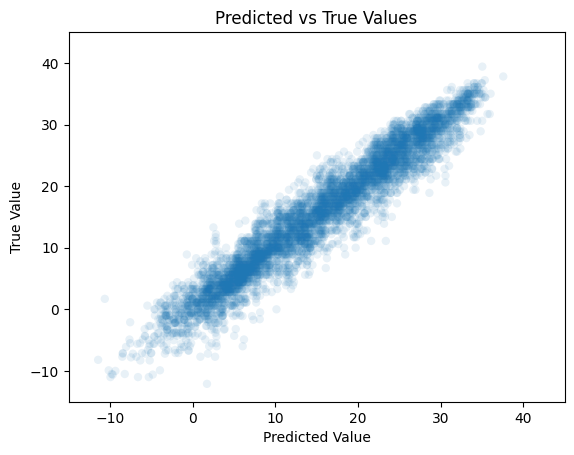

In [ ]:
plt.scatter(y_predict, y_test, alpha=0.1, edgecolor='none')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title ('Predicted vs True Values')
plt.xlim(-15, 45)
plt.ylim(-15, 45)
plt.show()

# Final Verdict: Linear Regression vs Random Forest Regression
In this scenario, it appears both linear regression and random forest regression are both extremely accurate in pedicting the values. However, linear regression does get a slight edge as the resulting scatterplot has points closer together (less obvious outliers) and has a sligthly higher correlation score, even though it's a difference of approximately 0.01. The experiment was run a few times and similar results were seen after each run.

This does not mean linear regression is always more accurate than random forest regression; it just happened to be in this scenario.